In [ ]:
os.makedirs("final_image_folder", exist_ok=True)

In [1]:
!pip install pymupdf
import fitz
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 58.7 MB/s eta 0:00:00


In [2]:
def extractpages(pdf,out):
  os.makedirs(out, exist_ok=True)

  # Open the PDF file
  pdf_document = fitz.open(pdf)

  for i in range(len(pdf_document)):
      page = pdf_document.load_page(i)
      pix = page.get_pixmap()
      # Save the image to a file
      image_path = "page_image.png"
      pix = page.get_pixmap()

      # Save the image to a file
      image_path = f"{out}/page_{i}.png"
      pix.save(image_path)


pdf="/content/pdf.pdf"
out="INPUT"
extractpages(pdf,out)

(841, 595)


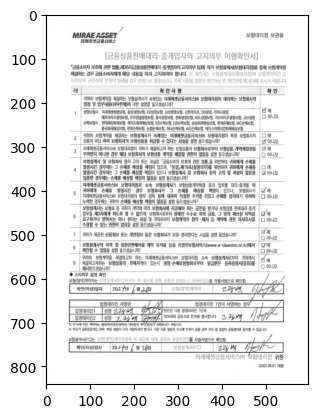

In [3]:
imgpath="/content/INPUT/page_0.png"  #replace with path of the image
img=cv2.imread(imgpath,0)
plt.imshow(img,cmap="gray")
img =cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)
print(img.shape)


In [4]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//40   #vary the kernel according to requirement
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

#obtain the vertical lines present in an image
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
img_temp1 = cv2.erode(img, vertical_kernel, iterations=3)
vertical_lines_img = cv2.dilate(img_temp1, vertical_kernel, iterations=3)
cv2.imwrite("vertical_lines.jpg",vertical_lines_img)

#obtain the horizontal lines present in an image
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
img_temp2 = cv2.erode(img, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
cv2.imwrite("horizontal_lines.jpg",horizontal_lines_img)

True

In [5]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha

# This function is used to add the vertical lines and horizontal lines to get a third image
img_bin = cv2.addWeighted(vertical_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_bin = cv2.erode(~img_bin, kernel, iterations=2)
(thresh, img_bin) = cv2.threshold(img_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_bin.jpg",img_bin)

True

[[56, 183, 490, 403], [52, 669, 493, 31]]


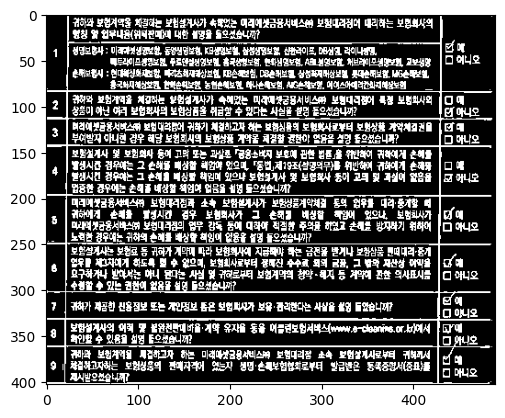

In [8]:
img_bin_tresh = cv2.adaptiveThreshold(img_bin, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Detect contours
contours, _ = cv2.findContours(img_bin_tresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#sort the contours
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])


table_coordinates = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w>50 and h>50: # adjust the ranges accordingly to get the required table coordinates
          table_coordinates.append([x, y+20, w, h-25]) #20 is added to remove the heading of the last column
          cv2.rectangle(img_bin, (x, y+20), (x + w, y + h), (255, 255, 0), 2)

# Save or display the image with rectangles
output_path = '/content/table_image.png'
cv2.imwrite(output_path, img_bin)

# Display coordinates
x, y, w, h = table_coordinates[0]
img_cropped = img[y:y+h, x:x+w]
print(table_coordinates)
plt.imshow(img_cropped,cmap="gray")

In [9]:

contours, _ = cv2.findContours(vertical_lines_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


vertical_lines_coordinates = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if h>400: # adjust the values to get the required vertical line
      vertical_lines_coordinates.append([x,y,w,h])

vertical_lines_coordinates.sort()
print("Vertical Lines Coordinates:", vertical_lines_coordinates)

coordinates=[]

#to detect the last column of the give table


if len(vertical_lines_coordinates) >= 2:
    x1,y,w,h=table_coordinates[0]
    x2=vertical_lines_coordinates[1][0]
    img2=img[y:y+h,x2:x1+w]
    coordinates=[(x2,y),(x2,y+h),(x1+w,y+h),(x1+w,y)]
    print("the coordinates are ")
    print(coordinates)

    cv2.imwrite("imgfinal.jpg", img2)
    print(img2.size)
    print(img2.shape)
else:
    print("Not enough vertical lines detected to perform the image slicing.")


Vertical Lines Coordinates: [[76, 166, 5, 423], [482, 167, 5, 423]]
the coordinates are 
[(482, 183), (482, 586), (546, 586), (546, 183)]
25792
(403, 64)
